## Jupyter notebook to tune and improve the Inception V3 model

PROGRAMER: Rafael Mata

DATE CREATED :  05 Oct 2021                                 
REVISED DATE :  20 Oct 2021
    
PURPOSE: Test different hyperparameters with the final Inception CNN Model to improve the accuracy performance

In [459]:
#Import libraries

import pandas as pd
import numpy as np
import os
from PIL import Image
import sys
import keras    
import cv2  
from keras.preprocessing import image  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import json
import matplotlib.pyplot as plt

In [432]:
def path_to_tensor(img_path):

    ''' Function to process and Image and convert from 3D to 4D Tensor , function taken from Udacity example notebook
    
        Params:
        --------
        img_path: string, path to the image

        Returns:
        4D tensor
    
    '''

    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [433]:
# Load the dog names from the json file
f = open ('dog_names.json', "r")
 
     # Reading from file
dog_names = json.loads(f.read())
 
f.close()

### Fine Tune the [Inception](https://keras.io/api/applications/inceptionv3) model

### Load the bottleneck features

In [434]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']

### Load train, valid and test targets

In [435]:
with open('bottleneck_features/train_targets.npy', 'rb') as f:
    train_targets = np.load(f)

In [436]:
with open('bottleneck_features/valid_targets.npy', 'rb') as f:
    valid_targets = np.load(f)

In [437]:
with open('bottleneck_features/test_targets.npy', 'rb') as f:
    test_targets = np.load(f)

### Create the model

In [438]:
def create_model():
    ''' Function to create the CNN Model to use with the Inception
    
        Params: None
        
        Returns:
        Inception_model : keras CNN model
    
    '''
    
    Inception_model = Sequential()
    Inception_model.add(GlobalAveragePooling2D(input_shape=train_Inception.shape[1:]))
    Inception_model.add(Dropout(0.45))
    Inception_model.add(Dense(256, activation='relu'))
    Inception_model.add(Dropout(0.45))
    Inception_model.add(Dense(133, activation='softmax'))
    
    return Inception_model

### Merge the Train and validation dataset to use K-FOLD

In [439]:
# Merge inputs and targets
inputs = np.concatenate((train_Inception, valid_Inception), axis=0)
targets = np.concatenate((train_targets, valid_targets), axis=0)

In [440]:
# Define the K-fold Cross Validator
num_folds = 8
kfold = KFold(n_splits=num_folds, shuffle=True)

In [441]:
# K-fold Cross Validation model evaluation
fold_no = 1

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

for train, validate in kfold.split(inputs, targets):
    
    print('FOLD NO: {}'.format(fold_no))
    # Create the model
    Inception_model = create_model()
    
    # Compile the model
    Inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    #Create checkpoint
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception_{}.hdf5'.format(fold_no), verbose=1, save_best_only=True)
    
    # Train the model
    Inception_model.fit(inputs[train], targets[train], validation_data=(inputs[validate], targets[validate]), epochs=30, batch_size=25, callbacks=[checkpointer],
                        verbose=0)
    
    scores = Inception_model.evaluate(inputs[validate], targets[validate], verbose=0)
    
    acc_per_fold.append(scores[1]*100)
    loss_per_fold.append(scores[0])
    
    print('--'*20)
    print('Fold no: {} Loss: {} Accuracy: {}'.format(fold_no, loss_per_fold, acc_per_fold))
    print('--'*20)
    
    # Increase fold number
    fold_no = fold_no + 1   

FOLD NO: 1

Epoch 00001: val_loss improved from inf to 0.91149, saving model to saved_models/weights.best.Inception_1.hdf5

Epoch 00002: val_loss improved from 0.91149 to 0.69808, saving model to saved_models/weights.best.Inception_1.hdf5

Epoch 00003: val_loss improved from 0.69808 to 0.69623, saving model to saved_models/weights.best.Inception_1.hdf5

Epoch 00004: val_loss improved from 0.69623 to 0.67145, saving model to saved_models/weights.best.Inception_1.hdf5

Epoch 00005: val_loss did not improve from 0.67145

Epoch 00006: val_loss did not improve from 0.67145

Epoch 00007: val_loss improved from 0.67145 to 0.61363, saving model to saved_models/weights.best.Inception_1.hdf5

Epoch 00008: val_loss did not improve from 0.61363

Epoch 00009: val_loss did not improve from 0.61363

Epoch 00010: val_loss did not improve from 0.61363

Epoch 00011: val_loss did not improve from 0.61363

Epoch 00012: val_loss did not improve from 0.61363

Epoch 00013: val_loss did not improve from 0.613

In [442]:
acc_per_fold

[82.02127814292908,
 82.87234306335449,
 85.42553186416626,
 84.45154428482056,
 84.77103114128113,
 85.83599328994751,
 82.64110684394836,
 84.45154428482056]

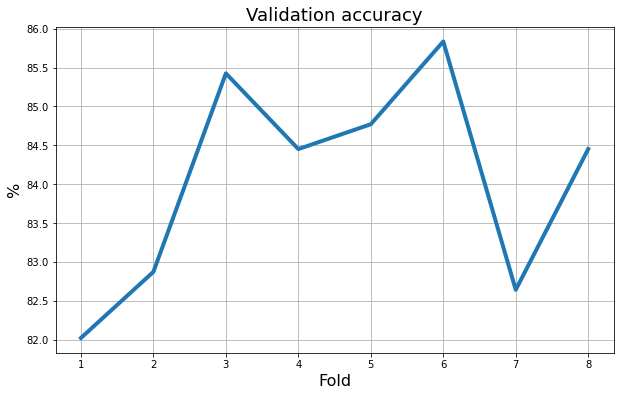

In [443]:
plt.figure(figsize=(10,6))
plt.plot(range(1,9),acc_per_fold,lw=4)
plt.title('Validation accuracy',fontsize=18)
plt.xlabel('Fold',fontsize=16)
plt.ylabel('%',fontsize=16);
plt.grid(True)

## Load the best model

In [445]:
Inception_model.load_weights('saved_models/weights.best.Inception_6.hdf5')

## Test the model

In [446]:
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.8612%


In [456]:
def extract_Inception_bottleneck():

    ''' Function to extract the InceptionV3 model from keras and generate the bottleneck feature
       
        Params: None

        Returns:
        --------
        Inception_bottleneck : InceptionV3 keras model with no top layers
 
    '''

    Inception_bottleneck = InceptionV3(weights='imagenet', include_top=False)

    return Inception_bottleneck

In [457]:

def Inception_predict_breed(img_path, model, Inception_bottleneck):
    bottleneck_feature = Inception_bottleneck.predict(preprocess_input(path_to_tensor(img_path)))
  
    # obtain predicted vector
    predicted_vector = Inception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    dog_name = dog_names[np.argmax(predicted_vector)].split('/')[2]
    dog_name = dog_name.split('.')[1]
    return dog_name

In [460]:
img_path = 'test_images/Chihuahua2.jpeg'
Inception_bottleneck = extract_Inception_bottleneck()

In [465]:
print('Possible Dog breed Detected: {}'.format(Inception_predict_breed(img_path,Inception_model, Inception_bottleneck)))

Possible Dog breed Detected: Chihuahua
